# Medical Segmentation Decathlon: Ingestion & Normalization

MSD Task06_Lung: 63 training CT scans with lung tumor segmentation masks (~8.5GB). [Dataset reference](http://medicaldecathlon.com/)

**Workflow:**
1. Ingest raw NIfTIs (original dimensions)
2. Transform with `map()` (resample to uniform spacing)
3. Write normalized collection (ML-ready)

In [1]:
import sys

sys.path.insert(0, "..")

import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from config import MSD_LUNG_URI, S3_REGION

from radiobject.ctx import S3Config, SliceOrientation, TileConfig, configure
from radiobject.radi_object import RadiObject

# Define URIs for raw and normalized data
MSD_LUNG_RAW_URI = MSD_LUNG_URI.replace("radiobject-2mm", "radiobject-raw")

print(f"Raw URI: {MSD_LUNG_RAW_URI}")
print(f"Normalized URI: {MSD_LUNG_URI}")

Raw URI: s3://souzy-scratch/msd-lung/radiobject-raw
Normalized URI: s3://souzy-scratch/msd-lung/radiobject-2mm


In [2]:
# Configure S3 access and tile layout
if MSD_LUNG_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))
configure(tile=TileConfig(orientation=SliceOrientation.ISOTROPIC))

# Data paths
S3_NIFTI_URI = "s3://souzy-scratch/msd-lung/nifti"
DATA_DIR = Path("../data/msd_lung/Task06_Lung")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Local data: {DATA_DIR.resolve()}")
print(f"Target: {MSD_LUNG_URI}")

Local data: /Users/samueldsouza/Desktop/Code/RadiObject/data/msd_lung/Task06_Lung
Target: s3://souzy-scratch/msd-lung/radiobject-2mm


In [3]:
def uri_exists(uri: str) -> bool:
    try:
        radi = RadiObject(uri)
        _ = radi.collection_names
        return True
    except Exception:
        return False


SKIP_RAW_INGESTION = uri_exists(MSD_LUNG_RAW_URI)
SKIP_NORMALIZATION = uri_exists(MSD_LUNG_URI)

print(f"Skip raw ingestion: {SKIP_RAW_INGESTION}")
print(f"Skip normalization: {SKIP_NORMALIZATION}")

Skip raw ingestion: False
Skip normalization: True


In [4]:
if not SKIP_RAW_INGESTION and not (DATA_DIR / "imagesTr").exists():
    print(f"Downloading from {S3_NIFTI_URI}...")
    result = subprocess.run(
        ["aws", "s3", "sync", S3_NIFTI_URI, str(DATA_DIR)],
        capture_output=True,
        text=True,
    )
    if result.returncode != 0:
        raise RuntimeError(f"Download failed: {result.stderr}")
    print("Download complete.")
elif not SKIP_RAW_INGESTION:
    print(f"Data exists at {DATA_DIR}")

Data exists at ../data/msd_lung/Task06_Lung


In [5]:
if not SKIP_RAW_INGESTION:
    radi_raw = RadiObject.from_niftis(
        uri=MSD_LUNG_RAW_URI,
        image_dir=DATA_DIR / "imagesTr",
        collection_name="CT",
        progress=True,
    )
    print(f"\nCreated raw: {radi_raw}")
    print(f"Raw collection shape: {radi_raw.CT.shape}")  # None = heterogeneous
elif uri_exists(MSD_LUNG_RAW_URI):
    radi_raw = RadiObject(MSD_LUNG_RAW_URI)
    print(f"Loaded existing raw: {radi_raw}")
    print(f"Raw collection shape: {radi_raw.CT.shape}")
else:
    radi_raw = None
    print("Raw data not available - will skip transform step")

Collections:   0%|          | 0/1 [00:00<?, ?coll/s]

Writing CT:   0%|          | 0/63 [00:00<?, ?vol/s]


Created raw: RadiObject(63 subjects, 1 collections: [CT])
Raw collection shape: None


## Transform with `map()`

In [ ]:
from scipy.ndimage import zoom


def resample_to_2mm(volume: np.ndarray) -> np.ndarray:
    """Resample volume to ~2mm isotropic spacing (2x downsample)."""
    return zoom(volume, 0.5, order=1)


if radi_raw is not None and not SKIP_NORMALIZATION:
    # Apply transform and write to new VolumeCollection
    normalized_vc = radi_raw.CT.map(resample_to_2mm).to_volume_collection(
        uri=f"{MSD_LUNG_URI}/collections/CT",
        progress=True,
    )
    print(f"Created normalized: {normalized_vc}")
else:
    print(f"Skipping - normalized data already exists at {MSD_LUNG_URI}")

## Verify Normalized Data

Subjects: 63
Collections: ('CT',)
Collection shape: (250, 250, 318)


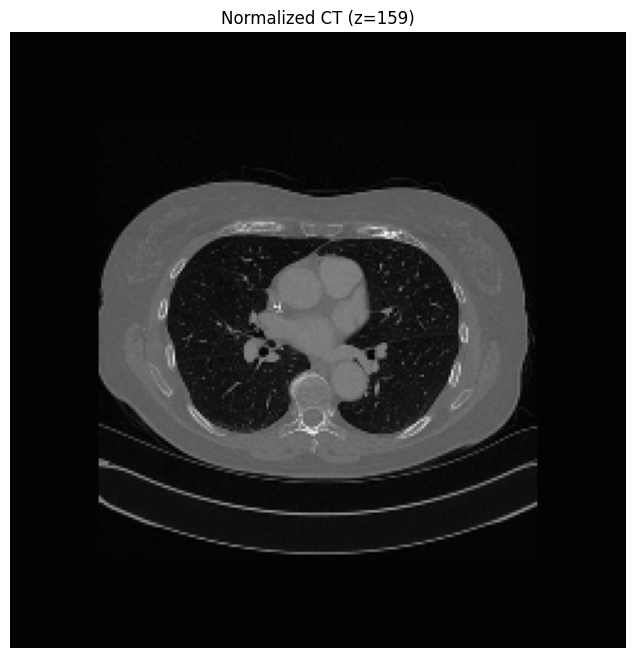

In [7]:
# Load the normalized RadiObject
radi = RadiObject(MSD_LUNG_URI)

print(f"Subjects: {len(radi)}")
print(f"Collections: {radi.collection_names}")
print(f"Collection shape: {radi.CT.shape}")

# Show sample volume
vol = radi.CT.iloc[0]
mid_z = vol.shape[2] // 2
plt.figure(figsize=(8, 8))
plt.imshow(vol.axial(z=mid_z).T, cmap="gray", origin="lower")
plt.title(f"Normalized CT (z={mid_z})")
plt.axis("off")
plt.show()

**Next:** [06_ml_training.ipynb](./06_ml_training.ipynb) - Train a classifier using this data.